# [ASI Project] Weight Uncertainty in Neural Networks  
**Authors**: Miriam Lamari, Francesco Giannuzzo  


In [87]:
import csv
import math
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torchvision import datasets
from torchvision import transforms
from kaggle_secrets import UserSecretsClient
from torch.utils.data import DataLoader, random_split
import wandb

In [88]:
user_secrets = UserSecretsClient()
key = user_secrets.get_secret('wandb-api-key')

wandb.login(key=key)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

## Minibatches
**minibatch_weight**(batch_idx: int, num_batches: int)

In [89]:
def minibatch_weight(batch_idx: int, num_batches: int) -> float:
    return 2 ** (num_batches - batch_idx) / (2 ** num_batches - 1)#batch_idx)

## Variational Approximation

In [90]:
from typing import Any, Optional

import torch.nn as nn
from torch import Tensor


class BayesianModule(nn.Module):

    """Base class for BNN to enable certain behaviour."""

    def __init__(self):
        super().__init__()

    def kld(self, *args):
        raise NotImplementedError('BayesianModule::kld()')


def variational_approximator(model: nn.Module) -> nn.Module:

    def kl_divergence(self) -> Tensor:

        kl = 0
        for module in self.modules():
            if isinstance(module, BayesianModule):
                kl += module.kl_divergence

        return kl

    # add `kl_divergence` to the model
    setattr(model, 'kl_divergence', kl_divergence)

    def elbo(self,
             inputs: Tensor,
             targets: Tensor,
             criterion: Any,
             n_samples: int,
             w_complexity: Optional[float] = 1.0) -> Tensor:

        loss = 0
        for sample in range(n_samples):
            outputs = self(inputs)
            loss += criterion(outputs, targets)
            loss += self.kl_divergence() * w_complexity

        return loss / n_samples

    # add `elbo` to the model
    setattr(model, 'elbo', elbo)

    return model


## Scale Mixture Prior

In [91]:
import functools as ft

import torch
import torch.nn as nn
from torch import Tensor


class ScaleMixture(nn.Module):

    """Scale Mixture Prior.

    Section 3.3 of the 'Weight Uncertainty in Neural Networks' paper
    proposes the use of a Scale Mixture prior for use in variational
    inference - this being a fixed-form prior.

    The authors note that, should the parameters be allowed to adjust
    during training, the prior changes rapidly and attempts to capture
    the empirical distribution of the weights. As a result the prior
    learns to fit poor initial parameters and struggles to improve.
    """

    def __init__(self, pi: float, sigma1: float, sigma2: float) -> None:

        """Scale Mixture Prior.

        The authors of 'Weight Uncertainty in Neural Networks' note:

            sigma1 > sigma2:
                provides a heavier tail in the prior density than is
                seen in a plain Gaussian prior.
            sigma2 << 1.0:
                causes many of the weights to a priori tightly
                concentrate around zero.

        Parameters
        ----------
        pi : float
            Parameter used to scale the two Gaussian distributions.
        sigma1 : float
            Standard deviation of the first normal distribution.
        sigma2 : float
            Standard deviation of the second normal distribution.
        """

        super().__init__()

        self.pi = pi
        self.sigma1 = sigma1
        self.sigma2 = sigma2

        self.normal1 = torch.distributions.Normal(0, sigma1)
        self.normal2 = torch.distributions.Normal(0, sigma2)

    def log_prior(self, w: Tensor) -> Tensor:

        """Log Likelihood of the weight according to the prior.

        Calculates the log likelihood of the supplied weight given the
        prior distribution - the scale mixture of two Gaussians.

        Parameters
        ----------
        w : Tensor
            Weight to be used to calculate the log likelihood.

        Returns
        -------
        Tensor
            Log likelihood of the weights from the prior distribution.
        """

        likelihood_n1 = torch.exp(self.normal1.log_prob(w))
        likelihood_n2 = torch.exp(self.normal2.log_prob(w))

        p_scalemixture = self.pi * likelihood_n1 + (1 - self.pi) * likelihood_n2
        log_prob = torch.log(p_scalemixture).sum()

        return log_prob

## Gaussian Variational Inference

In [92]:
import numpy as np
import torch
import torch.nn as nn
from torch import Tensor


class GaussianVariational(nn.Module):
    def __init__(self, mu: Tensor, rho: Tensor) -> None:

        super().__init__()

        self.mu = nn.Parameter(mu)
        self.rho = nn.Parameter(rho)

        self.w = None
        self.sigma = None

        self.normal = torch.distributions.Normal(0, 1)

    def sample(self) -> Tensor:
        device = self.mu.device
        epsilon = self.normal.sample(self.mu.size()).to(device)
        self.sigma = torch.log(1 + torch.exp(self.rho)).to(device)
        self.w = self.mu + self.sigma * epsilon

        return self.w

    def log_posterior(self) -> Tensor:

        if self.w is None:
            raise ValueError('self.w must have a value.')

        log_const = np.log(np.sqrt(2 * np.pi))
        log_exp = ((self.w - self.mu) ** 2) / (2 * self.sigma ** 2)
        log_posterior = -log_const - torch.log(self.sigma) - log_exp

        return log_posterior.sum()

## Bayesian Linear Layer ##

In [93]:
from typing import Optional

import torch
import torch.nn.functional as F
from torch import Tensor

#from .base_bayesian import BayesianModule
#from .samplers.gaussian_variational import GaussianVariational
#from .samplers.scale_mixture import ScaleMixture


class BayesLinear(BayesianModule):

    """Bayesian Linear Layer.

    Implementation of a Bayesian Linear Layer as described in the
    'Weight Uncertainty in Neural Networks' paper.
    """

    def __init__(self,
                 in_features: int,
                 out_features: int,
                 prior_pi: Optional[float] = 0.5,
                 prior_sigma1: Optional[float] = 1.0,
                 prior_sigma2: Optional[float] = 0.0025) -> None:

        super().__init__()

        w_mu = torch.empty(out_features, in_features).uniform_(-0.2, 0.2)
        w_rho = torch.empty(out_features, in_features).uniform_(-5.0, -4.0)

        bias_mu = torch.empty(out_features).uniform_(-0.2, 0.2)
        bias_rho = torch.empty(out_features).uniform_(-5.0, -4.0)

        self.w_posterior = GaussianVariational(w_mu, w_rho)
        self.bias_posterior = GaussianVariational(bias_mu, bias_rho)

        self.w_prior = ScaleMixture(prior_pi, prior_sigma1, prior_sigma2)
        self.bias_prior = ScaleMixture(prior_pi, prior_sigma1, prior_sigma2)

        self.kl_divergence = 0.0

    def forward(self, x: Tensor) -> Tensor:

        w = self.w_posterior.sample()
        b = self.bias_posterior.sample()

        w_log_prior = self.w_prior.log_prior(w)
        b_log_prior = self.bias_prior.log_prior(b)

        w_log_posterior = self.w_posterior.log_posterior()
        b_log_posterior = self.bias_posterior.log_posterior()

        total_log_prior = w_log_prior + b_log_prior
        total_log_posterior = w_log_posterior + b_log_posterior
        self.kl_divergence = self.kld(total_log_prior, total_log_posterior)

        return F.linear(x, w, b)

    def kld(self, log_prior: Tensor, log_posterior: Tensor) -> Tensor:
        return log_posterior - log_prior

In [94]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {}

In [95]:
def train_wrapper():
    run = wandb.init(project="Project-ASI")

    return train_loop(
        learning_rate = wandb.config.learning_rate,
        prior_pi = wandb.config.prior_pi,
        prior_sigma1=wandb.config.prior_sigma1,
        prior_sigma2=wandb.config.prior_sigma2
    )

## Tuning Hyperparamters

In [96]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.metrics import mean_squared_error

def generate_data(n_samples=3000):
    x = np.linspace(-0.4, 1.2, n_samples)
    eps = np.random.normal(0, 0.02, size=n_samples)
    y = x + 0.3 * np.sin(2 * np.pi * (x + eps)) + 0.3 * np.sin(4 * np.pi * (x + eps)) + eps
    x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
    y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    return x, y

In [97]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import wandb

def train_loop(learning_rate, prior_pi, prior_sigma1, prior_sigma2, epochs=200):
    run = wandb.init(project="Project-ASI")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    @variational_approximator
    class BayesianNetwork(nn.Module):
        def __init__(self, input_dim, output_dim):
            super().__init__()
            self.bl1 = BayesLinear(input_dim, 400, prior_pi, prior_sigma1, prior_sigma2)
            self.bl2 = BayesLinear(400, 400, prior_pi, prior_sigma1, prior_sigma2)
            self.bl3 = BayesLinear(400, output_dim, prior_pi, prior_sigma1, prior_sigma2)
    
        def forward(self, x):
            x = F.relu(self.bl1(x))
            x = F.relu(self.bl2(x))
            x = self.bl3(x)
            self.kl_divergence = (
                self.bl1.kl_divergence +
                self.bl2.kl_divergence +
                self.bl3.kl_divergence
            )
            return x

    # Data preparation
    x, y = generate_data()
    full_dataset = TensorDataset(x, y)

    test_size = int(0.2 * len(full_dataset))
    val_size = int(0.3 * (len(full_dataset) - test_size))
    train_size = len(full_dataset) - test_size - val_size

    train_set, val_set, test_set = random_split(full_dataset, [train_size, val_size, test_size])
    trainloader = DataLoader(train_set, batch_size=32, shuffle=True)
    valloader = DataLoader(val_set, batch_size=32)
    testloader = DataLoader(test_set, batch_size=32)

    # Model and optimizer
    model = BayesianNetwork(1, 2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.GaussianNLLLoss(full=True, reduction='sum')

    # Training loop
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for batch_idx, (x_batch, y_batch) in enumerate(trainloader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            pi_weight = minibatch_weight(batch_idx=batch_idx, num_batches=len(trainloader))

            output = model(x_batch)
            mean = output[:, 0:1]
            variance = F.softplus(output[:, 1:2]) + 1e-6
            nll = criterion(mean, y_batch, variance)
            kld = model.kl_divergence
            loss = nll + pi_weight * kld

            train_loss += loss.item()
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_loss = 0.0
        val_rmse = 0.0
        with torch.no_grad():
            for batch_idx, (x_batch, y_batch) in enumerate(valloader):
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                output = model(x_batch)
                mean = output[:, 0:1]
                variance = F.softplus(output[:, 1:2]) + 1e-6
                nll = criterion(mean, y_batch, variance)
                kld = model.kl_divergence
                loss = nll + pi_weight * kld
                val_loss += loss.item()
                val_rmse += torch.sum((mean - y_batch) ** 2).item()

        val_rmse = np.sqrt(val_rmse / len(val_set))
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.2f} | Val Loss: {val_loss:.2f} | Val RMSE: {val_rmse:.4f}")
        wandb.log({'train_loss': train_loss, 'val_loss': val_loss, 'val_rmse': val_rmse})

    # === Plot predictive uncertainty ===
    plot_predictions(model, trainloader, testloader, n_samples=3000, device=device)

# ----------------------------------------
# Helper for MC Sampling and Plotting
# ----------------------------------------
def predict_with_uncertainty(model, x, n_samples=200):
    model.eval()
    preds = []
    with torch.no_grad():
        for _ in range(n_samples):
            output = model(x)
            mean = output[:, 0:1]
            preds.append(mean.cpu().numpy())
    preds = np.stack(preds, axis=0)  # (n_samples, N, 1)
    predictive_mean = np.mean(preds, axis=0).squeeze()
    predictive_std = np.std(preds, axis=0).squeeze()
    return predictive_mean, predictive_std
'''
def plot_predictions(model, testloader, n_samples=100, device='cpu'):
    X_all = []
    Y_all = []
    for x_batch, y_batch in testloader:
        X_all.append(x_batch)
        Y_all.append(y_batch)
    X_all = torch.cat(X_all).to(device)
    Y_all = torch.cat(Y_all).cpu().numpy()
    
    predictive_mean, predictive_std = predict_with_uncertainty(model, X_all, n_samples=n_samples)
    X_np = X_all.cpu().numpy().squeeze()

    sorted_idx = np.argsort(X_np)
    X_np = X_np[sorted_idx]
    Y_all = Y_all[sorted_idx]
    predictive_mean = predictive_mean[sorted_idx]
    predictive_std = predictive_std[sorted_idx]

    # Plot
    plt.figure(figsize=(6, 4))
    plt.plot(X_np, predictive_mean, color='red', label='Predictive Mean')
    plt.fill_between(X_np, predictive_mean - 2*predictive_std, predictive_mean + 2*predictive_std, color='blue', alpha=0.2, label='±2 std')
    plt.fill_between(X_np, predictive_mean - 1*predictive_std, predictive_mean + 1*predictive_std, color='cyan', alpha=0.4, label='±1 std')
    plt.scatter(X_np, Y_all, color='black', s=5, alpha=0.6, label='Ground Truth')
    plt.ylim(-0.5, 1.2)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Predictive Distribution with Uncertainty")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
'''

def plot_predictions(model, trainloader, testloader, n_samples=100, device='cpu'):
    # === 1. Gather all data ===
    X_train = []
    Y_train = []
    for x_batch, y_batch in trainloader:
        X_train.append(x_batch)
        Y_train.append(y_batch)
    X_train = torch.cat(X_train).to(device)
    Y_train = torch.cat(Y_train).cpu().numpy()

    X_test = []
    Y_test = []
    for x_batch, y_batch in testloader:
        X_test.append(x_batch)
        Y_test.append(y_batch)
    X_test = torch.cat(X_test).to(device)
    Y_test = torch.cat(Y_test).cpu().numpy()

    # === 2. Concatenate all Xs for prediction ===
    X_all = torch.cat([X_train, X_test], dim=0)
    predictive_mean, predictive_std = predict_with_uncertainty(model, X_all, n_samples=n_samples)
    X_np = X_all.cpu().numpy().squeeze()

    # === 3. Sort everything for nice plots ===
    sorted_idx = np.argsort(X_np)
    X_np = X_np[sorted_idx]
    predictive_mean = predictive_mean[sorted_idx]
    predictive_std = predictive_std[sorted_idx]

    # === 4. Plot ===
    plt.figure(figsize=(7, 4.5))
    plt.plot(X_np, predictive_mean, color='red', label='Predictive Mean')
    plt.fill_between(X_np, predictive_mean - 2*predictive_std, predictive_mean + 2*predictive_std, color='blue', alpha=0.2, label='±2 std')
    plt.fill_between(X_np, predictive_mean - 1*predictive_std, predictive_mean + 1*predictive_std, color='cyan', alpha=0.4, label='±1 std')

    plt.scatter(X_train.cpu().numpy(), Y_train, color='black', s=10, label='Train Data')
    plt.scatter(X_test.cpu().numpy(), Y_test, color='gray', s=6, label='Test Data', alpha=0.5)

    plt.ylim(-0.5, 1.2)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("BNN Predictive Distribution with Train & Test Data")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


train_loss,█▆▅▅▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▄▃▄▃▂▃▄▅▃▂▂▄▂▂▂▂▄▂▃▂▂▂▂▁▂▂▂▁▁▁▁▁▁▂▁▂▁
val_rmse,█▆▇▃▃▃▂▂▃▃▂▂▃▄▄▂▂▃▂▂▄▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▂▂▁
train_loss,264228.49317
val_loss,-588.48706
val_rmse,0.11038


Epoch 1/100 | Train Loss: 1465598.00 | Val Loss: 29.04 | Val RMSE: 0.2521
Epoch 2/100 | Train Loss: 1440524.94 | Val Loss: 138.91 | Val RMSE: 0.2892
Epoch 3/100 | Train Loss: 1418065.24 | Val Loss: 79.72 | Val RMSE: 0.2710
Epoch 4/100 | Train Loss: 1396144.52 | Val Loss: -135.88 | Val RMSE: 0.1890
Epoch 5/100 | Train Loss: 1378202.96 | Val Loss: -209.38 | Val RMSE: 0.1824
Epoch 6/100 | Train Loss: 1360433.11 | Val Loss: -196.64 | Val RMSE: 0.1823
Epoch 7/100 | Train Loss: 1345692.11 | Val Loss: -283.00 | Val RMSE: 0.1650
Epoch 8/100 | Train Loss: 1332038.47 | Val Loss: -246.19 | Val RMSE: 0.1754
Epoch 9/100 | Train Loss: 1319432.58 | Val Loss: 36.84 | Val RMSE: 0.2299
Epoch 10/100 | Train Loss: 1307761.73 | Val Loss: -266.32 | Val RMSE: 0.1689
Epoch 11/100 | Train Loss: 1296157.85 | Val Loss: -306.77 | Val RMSE: 0.1375
Epoch 12/100 | Train Loss: 1284199.12 | Val Loss: 58.70 | Val RMSE: 0.1955
Epoch 13/100 | Train Loss: 1274574.95 | Val Loss: 68.70 | Val RMSE: 0.2205
Epoch 14/100 | Trai

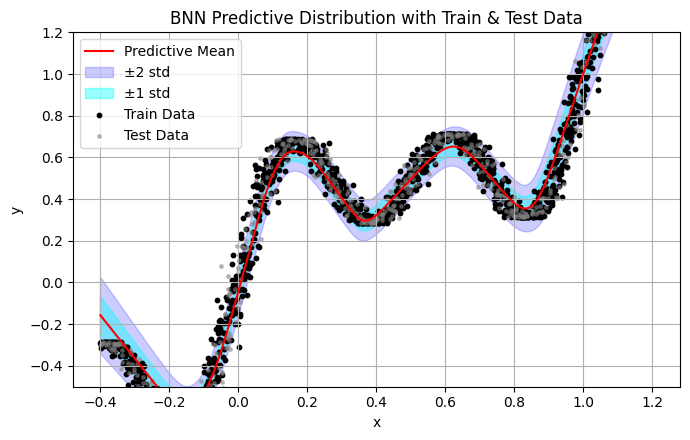

In [98]:
sweep_configuration = {
     "method": "grid",
     "metric": {"goal": "minimize", "name": "val_loss"},
     'name': "sweep-BBB-Gaussian_regression",
     "parameters": {
         "learning_rate": {'values': [1e-3, 1e-4]},
         "prior_pi": {'values': [0.25, 0.5]},
         "prior_sigma1": {'values': [1, math.exp(-1)]},
         "prior_sigma2": {'values': [math.exp(-6), math.exp(-7)]},
     },
}
'''
sweep_id = wandb.sweep(sweep=sweep_configuration, project="Project-ASI")
wandb.agent(sweep_id, function=train_wrapper);
'''

wandb.init(project="Project-ASI")
best_hyperparameters  = { 'learning_rate':0.001, 'prior_pi':0.5, 'prior_sigma1':1, 'prior_sigma2':0.0024787521766663585}
train_loop(
    learning_rate = best_hyperparameters['learning_rate'],
    prior_pi = best_hyperparameters['prior_pi'],
    prior_sigma1 = best_hyperparameters['prior_sigma1'],
    prior_sigma2 = best_hyperparameters['prior_sigma2'],
    epochs = 100
)